## Monte Carlo Simulation for Casino Blackjack
This simulation is intended to build the probabilistic model of winning a casino blackjack given that we are using the following strategies:
```
if total_cards == 11:
    double

while total_cards < 10:
    hit

while total_cards <= 21:
    if dealer_card <= 6 or dealer_card < total_cards - 10 or total_cards > 16:
        stand
    else:
        hit
```

In [1]:
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

In [2]:
CARDS = ['A', '2', '3', '4', '5', '6', '7', '8', '9', '10', 'J', 'Q', 'K']
VALUE = [[1, 11], 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10]
N_DECKS = 6
N_CARD_EACH_DECK = 4
START_COUNT = [N_DECKS * N_CARD_EACH_DECK] * len(CARDS)
PLOT_COLOR = '#4169e1'
MIN_BET = 15

In [3]:
def draw_a_card(count, total):
    '''
        function to simulate drawing of a card, which going to reduce
        the pool of the card drawn and add the total to the current possible totals.
        
        Parameters
        ----------
        count: list
            A list of the running count of each card
        total: int
            The total running sum of the palyer/dealer
            
        Output
        ------
            total_sum, updated_count
    '''
    
    prob = [x/sum(count) for x in count]
    index = np.random.choice(len(CARDS), replace = True, p = prob)
    value = VALUE[index]
    updated_count = count.copy()
    updated_count[index] = updated_count[index] - 1
    
    if type(total) == list:
        if index == 0:
            total_sum = [val1 + val2 for val1 in total for val2 in value]
        else:
            total_sum = [val1 + value for val1 in total]
    else:
        if index == 0:
            total_sum = [total + val2 for val2 in value]
        else:
            total_sum = total + value

    return total_sum, updated_count

### Dealer Probability Distribution
First part of what we interest the most is what is the probability distribution of the dealer's hand? what are the chances that the dealer bust based on the standard strategy of hit on soft-16 and having 22 to be a stand-off. 

In [4]:
def draw_a_card(count, total):
    prob = [x/sum(count) for x in count]
    index = np.random.choice(len(CARDS), replace = True, p = prob)
    value = VALUE[index]
    updated_count = count.copy()
    updated_count[index] = updated_count[index] - 1
    
    if type(total) == list:
        if index == 0:
            total_sum = [val1 + val2 for val1 in total for val2 in value]
        else:
            total_sum = [val1 + value for val1 in total]
    else:
        if index == 0:
            total_sum = [total + val2 for val2 in value]
        else:
            total_sum = total + value

    return total_sum, updated_count

In [5]:
## Dealer distribution of result
n_sim = 25000
sim_r = []

count = START_COUNT.copy()
for i in range(n_sim):
    if sum(count) < 260: 
        count = START_COUNT.copy() # If a total of a deck has been used, it is reshuffled again
    
    total_sum, count = draw_a_card(count, 0)
    
    while np.max(total_sum) <= 16:
        total_sum, count = draw_a_card(count, total_sum)
    
    sim_r.append(np.max(total_sum))

In [6]:
## What is the probability of dealer to bust
p_bust = sum([val > 22 for val in sim_r])/n_sim

## What is the probability of dealer to standoffs
p_stof = sum([val == 22 for val in sim_r])/n_sim

## Probability of dealer having high cards (18 19 20)
p_high = (sum([val < 21 for val in sim_r]) - sum([val < 18 for val in sim_r]))/n_sim

## Probability of dealer having blackjack
p_bljk = sum([val == 21 for val in sim_r])/n_sim

print(f"Bust: {p_bust},  Stand-off: {p_stof}, High: {p_high}, Blackjack: {p_bljk}")

Bust: 0.24676,  Stand-off: 0.07816, High: 0.4328, Blackjack: 0.11136


However, these probabilities are assuming that the dealers are playing by themselves, as the probability is changed every single cards were drawn, when playing with another player, the probability should've changed but not in substantial amount. The probability density can be illustrated as follows.

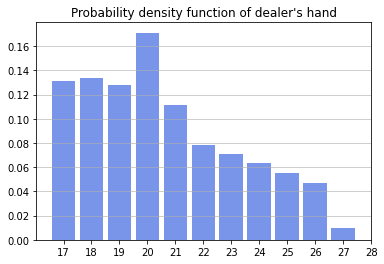

In [7]:
n_possible_values = len(set(sim_r)) + 1

n, bins, patches = plt.hist(x = sim_r, bins = np.arange(n_possible_values) + min(sim_r) - 0.5, color = PLOT_COLOR,
                            alpha=0.7, rwidth=0.85, density = True)
plt.grid(axis='y', alpha=0.75)
plt.xticks(np.arange(n_possible_values) + min(sim_r))
plt.title("Probability density function of dealer's hand")
plt.show()

In [5]:
## Playing alone with dealer
n_sim = 25000
sim_r = []
sim_p = []
sim_d = []

count = START_COUNT.copy()
for i in tqdm(range(n_sim)):
    if sum(count) < 260: 
        count = START_COUNT.copy() # If a total of a deck has been used, it is reshuffled again
    
    bet_value = MIN_BET
    
    player_total_sum, count = draw_a_card(count, 0)
    dealer_total_sum, count = draw_a_card(count, 0)
    player_total_sum, count = draw_a_card(count, player_total_sum)
    
    card_drawn = 2
    
    if np.max(player_total_sum) == 11:
        player_total_sum, count = draw_a_card(count, player_total_sum)
        card_drawn += 1
        bet_value += MIN_BET
    else:
        while np.max(player_total_sum) <= 10:
            player_total_sum, count = draw_a_card(count, player_total_sum)
            card_drawn += 1

        while np.max(player_total_sum) < 14:
            if np.max(dealer_total_sum) <= 6 or np.max(dealer_total_sum) <= np.max(player_total_sum) - 10:
                break
            else:
                player_total_sum, count = draw_a_card(count, player_total_sum)
                card_drawn += 1
    
    while np.max(dealer_total_sum) <= 16:
        dealer_total_sum, count = draw_a_card(count, dealer_total_sum)
    
    if np.max(player_total_sum) == 21 and card_drawn == 2:
        sim_r.append(bet_value * 1.5)
    elif card_drawn >= 5 or np.max(player_total_sum) == 21:
        sim_r.append(bet_value)
    elif np.max(player_total_sum) > 21:
        sim_r.append(-bet_value)
    elif np.max(dealer_total_sum) > 21:
        sim_r.append(bet_value)
    elif np.max(dealer_total_sum) == 22:
        sim_r.append(0)
    else:
        sim_r.append(np.sign(np.max(player_total_sum) - np.max(dealer_total_sum)) * bet_value)
        
    sim_p.append(np.max(player_total_sum))
    sim_d.append(np.max(dealer_total_sum))

100%|██████████████████████████████████████████████████████████████████████████| 25000/25000 [00:03<00:00, 6274.11it/s]


In [6]:
## What is the probability of dealer to bust
p_bust_d = sum([val > 22 for val in sim_d])/n_sim

## What is the probability of dealer to standoffs
p_stof = sum([val == 22 for val in sim_d])/n_sim

## Probability of dealer having high cards (18 19 20)
p_high_d = (sum([val < 21 for val in sim_d]) - sum([val < 18 for val in sim_d]))/n_sim

## Probability of dealer having blackjack
p_bljk_d = sum([val == 21 for val in sim_d])/n_sim

## Probability of dealer wins
p_win_d  = sum([val < 0 for val in sim_r])/n_sim

print(f"Bust: {p_bust_d},  Stand-off: {p_stof}, High: {p_high_d}, Blackjack: {p_bljk_d}, Probability of Dealer to Win: {p_win_d}")

Bust: 0.24776,  Stand-off: 0.07512, High: 0.43308, Blackjack: 0.11388, Probability of Dealer to Win: 0.48364


In [7]:
## What is the probability of player to bust
p_bust_p = sum([val > 22 for val in sim_p])/n_sim

## Probability of player having high cards (18 19 20)
p_high_p = (sum([val < 21 for val in sim_p]) - sum([val < 18 for val in sim_p]))/n_sim

## Probability of player having blackjack
p_bljk_p = sum([val == 21 for val in sim_p])/n_sim

## Probability of player wins
p_win_p  = sum([val > 0 for val in sim_r])/n_sim

print(f"Bust: {p_bust_p}, High: {p_high_p}, Blackjack: {p_bljk_p}, Probability of Player to Win: {p_win_p}")

Bust: 0.02912, High: 0.32272, Blackjack: 0.08176, Probability of Player to Win: 0.45416


It is remarkable to see that the probability of player to win is significantly different to dealer's (by around 3% differences), which indicates that this strategy is a losing-game for the player. The following shows the probability density function for the values of both player and dealer as well as the running total of the player's winnings.

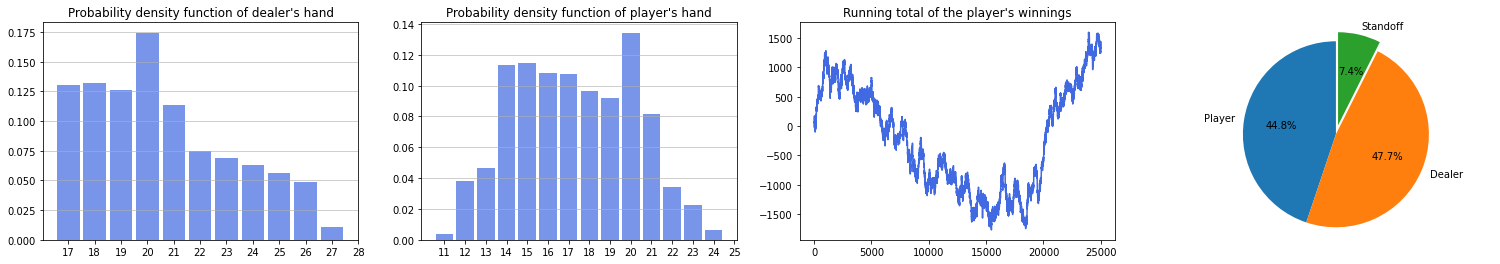

In [8]:
labels = 'Player', 'Dealer', 'Standoff'
sizes = [p_win_p, p_win_d, p_stof]
explode = (0, 0, 0.1)
n_possible_player_values = len(set(sim_p)) + 1
n_possible_dealer_values = len(set(sim_d)) + 1

fig, ax = plt.subplots(1, 4, figsize = (26, 4))
ax[0].hist(x = sim_d, bins = np.arange(n_possible_dealer_values) + min(sim_d) - 0.5, color = PLOT_COLOR,
                            alpha=0.7, rwidth=0.85, density = True)
ax[0].grid(axis='y', alpha=0.75)
ax[0].set_xticks(np.arange(n_possible_dealer_values) + min(sim_d))
ax[0].set_title("Probability density function of dealer's hand")

ax[1].hist(x = sim_p, bins = np.arange(n_possible_player_values) + min(sim_p) - 0.5, color = PLOT_COLOR,
                            alpha=0.7, rwidth=0.85, density = True)
ax[1].grid(axis='y', alpha=0.75)
ax[1].set_xticks(np.arange(n_possible_player_values) + min(sim_p))
ax[1].set_title("Probability density function of player's hand")

ax[2].plot(np.cumsum(sim_r), color = PLOT_COLOR)
ax[2].set_title("Running total of the player's winnings")

ax[3].pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', startangle=90)
ax[3].axis('equal')
plt.show()